In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import AveragePooling1D, Reshape
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose,
    UpSampling1D, SpatialDropout1D, Dense, Flatten, BatchNormalization, AveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.initializers import HeUniform
import csv
import os
import pandas as pd
from transformers import BertTokenizer
from datasets import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Specify the parent directory containing the folders with CSV files
folder_path_baseline = '/kaggle/input/ogw2-processed/OGW2_processed/Baseline'
folder_path_damage='/kaggle/input/ogw2-processed/OGW2_processed/Damage'

# # Initialize lists to store data and labels
# data_list = []
# labels_list = []

In [3]:
# Function to process pristine (undamaged) samples
def process_csv_files_udam(parent_directory_target_udam, target_database):
    sample_id_counter = 1

    # Define the allowed frequency range (40kHz to 160kHz)
    allowed_frequencies = set(range(40, 161, 20))  # [40, 60, 80, ..., 160]

    # Iterate over each file in the parent directory
    for filename in os.listdir(parent_directory_target_udam):
        filepath = os.path.join(parent_directory_target_udam, filename)

        # Check if the file is a CSV and contains a valid frequency in the name
        if filename.endswith('.csv'):
            try:
                # Extract the frequency from the filename (e.g., 20181222T030033_data_260kHz.csv)
                frequency_str = filename.split('_data_')[1].replace('kHz.csv', '')
                frequency = int(frequency_str)

                # Check if the frequency is within the allowed range
                if frequency in allowed_frequencies:
                    # Read data from CSV file and select columns 3 and 4 (index 2 and 3)
                    with open(filepath, 'r') as file:
                        reader = csv.reader(file)
                        data = np.array([[row[2], row[3]] for row in reader], dtype=float)  # Select columns 3 and 4

                    # Split the (4370, 2) matrix into two separate 1D sequences
                    sequence1 = data[:, 0]  # Column 3 as 1D sequence
                    sequence2 = data[:, 1]  # Column 4 as 1D sequence

                    # Create two separate samples with the same label (0 for undamaged)
                    sample1 = {'Sample ID': sample_id_counter, 'Condition': 0, 'Data': sequence1.tolist()}
                    sample2 = {'Sample ID': sample_id_counter + 1, 'Condition': 0, 'Data': sequence2.tolist()}

                    # Add samples to the database
                    target_database.append(sample1)
                    target_database.append(sample2)

                    # Increment the sample ID counter
                    sample_id_counter += 2

            except (IndexError, ValueError):
                # Skip the file if frequency extraction fails
                continue




In [4]:
# Function to process damaged samples
def process_csv_files_dam(folder_path, database):
    sample_id_counter = 1

    # Define the allowed frequency range (40kHz to 160kHz)
    allowed_frequencies = set(range(40, 161, 20))  # [40, 60, 80, ..., 160]

    if os.path.isdir(folder_path):
        # Iterate over each CSV file in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.csv'):
                try:
                    # Extract the frequency from the filename (e.g., 20181222T030033_data_260kHz.csv)
                    frequency_str = filename.split('_data_')[1].replace('kHz.csv', '')
                    frequency = int(frequency_str)

                    # Check if the frequency is within the allowed range
                    if frequency in allowed_frequencies:
                        # Read data from CSV file and select columns 3 and 4 (index 2 and 3)
                        with open(os.path.join(folder_path, filename), 'r') as file:
                            reader = csv.reader(file)
                            data = np.array([[row[2], row[3]] for row in reader], dtype=float)  # Select columns 3 and 4

                        # Split the (4370, 2) matrix into two separate 1D sequences
                        sequence1 = data[:, 0]  # Column 3 as 1D sequence
                        sequence2 = data[:, 1]  # Column 4 as 1D sequence

                        # Create two separate samples with the same label (1 for damaged)
                        sample1 = {'Sample ID': sample_id_counter, 'Condition': 1, 'Data': sequence1.tolist()}
                        sample2 = {'Sample ID': sample_id_counter + 1, 'Condition': 1, 'Data': sequence2.tolist()}

                        # Add samples to the database
                        database.append(sample1)
                        database.append(sample2)

                        # Increment the sample ID counter
                        sample_id_counter += 2

                except (IndexError, ValueError):
                    # Skip the file if frequency extraction fails
                    continue

In [5]:
# Process the samples
udam = []
process_csv_files_udam(folder_path_baseline, udam)
print(len(udam))

4508


In [6]:
dam = []
process_csv_files_dam(folder_path_damage, dam)
print(len(dam))

2254


In [7]:
# Function to normalize a list of samples (either udam or dam) to the range [0, 1]
def normalize_samples(samples):
    for sample in samples:
        data = np.array(sample['Data'])
        
        # Calculate the min and max values
        min_val = np.min(data)
        max_val = np.max(data)
        
        # Apply min-max scaling
        if max_val > min_val:  # To avoid division by zero
            scaled_data = (data - min_val) / (max_val - min_val)
        else:
            scaled_data = data  # If min and max are the same, keep the data unchanged
            
        # Update the sample with the scaled data
        sample['Data'] = scaled_data.tolist()

# Example usage: Normalize both udam and dam
normalize_samples(udam)
normalize_samples(dam)

print("Data normalization complete.")

Data normalization complete.


In [8]:
import numpy as np

# Function to augment damaged data samples
def augment_damaged_data(damaged_samples, augment_factor=1, noise_level=0.01):
    augmented_samples = []
    
    for sample in damaged_samples:
        original_data = np.array(sample['Data'])
        
        for _ in range(augment_factor):
            # Create noise and apply to the original data
            noise = np.random.normal(0, noise_level, original_data.shape)
            augmented_data = original_data + noise
            
            # Create an augmented sample with the same metadata
            augmented_sample = {
                'Sample ID': f"{sample['Sample ID']}_aug",
                'Condition': sample['Condition'],  # Keep the same condition
                'Data': augmented_data.tolist()
            }
            
            # Append the augmented sample to the augmented_samples list
            augmented_samples.append(augmented_sample)
    
    return augmented_samples



In [9]:
# Example usage
dam_augmented = augment_damaged_data(dam, augment_factor=1, noise_level=0.01)
dam.extend(dam_augmented)

In [10]:
print(f"Total damaged samples after augmentation: {len(dam)}")

Total damaged samples after augmentation: 4508


In [11]:
combined_database=udam + dam

In [12]:
print(f"Total undamaged samples after augmentation: {len(udam)}")

Total undamaged samples after augmentation: 4508


In [13]:
import random
from sklearn.model_selection import train_test_split
# Combine undamaged and damaged samples into one dataset
full_database = udam + dam

# Shuffle the combined database
random.shuffle(full_database)

# Extract data (features) and labels (targets) from the full_database
data = [sample['Data'] for sample in full_database]  # This will be your X
labels = [sample['Condition'] for sample in full_database]  # This will be your y

# Perform an 80/20 split for training and testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert lists to NumPy arrays for compatibility with machine learning models
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Print the shapes of the resulting arrays for verification
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (7212, 4370)
y_train shape: (7212,)
x_test shape: (1804, 4370)
y_test shape: (1804,)


In [14]:
# Downsample by taking the maximum of every 5 consecutive points
x_train_max = np.max(x_train.reshape(x_train.shape[0], -1, 5), axis=2)
x_test_max = np.max(x_test.reshape(x_test.shape[0], -1, 5), axis=2)

# Check the new shape
print(f"x_train_max shape: {x_train_max.shape}")
print(f"x_test_max shape: {x_test_max.shape}")


x_train_max shape: (7212, 874)
x_test_max shape: (1804, 874)


In [15]:
# Define your callbacks
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
# Define a MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 2


In [16]:
!pip install transformers

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [17]:
# Multi-GPU setup
strategy = tf.distribute.MirroredStrategy()

In [18]:

# Transformer Encoder block definition
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


In [19]:
# Model building function
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    # Reshape the input to 3D (batch_size, 4370, 1)
    x = layers.Reshape((input_shape[0], 1))(inputs)
    #x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Flatten the tensor instead of reshaping
    x = layers.Flatten()(x)
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    # Output layer for binary classification
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


In [20]:
# Multi-GPU strategy scope
with strategy.scope():
    input_shape = (874,)  # Adjusted input shape

    model = build_model(
        input_shape,
        head_size=512,
        num_heads=8,
        ff_dim=128,
        num_transformer_blocks=4,
        mlp_units=[256],
        mlp_dropout=0.4,
        dropout=0.3,
    )

    # Compilation with binary classification loss
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"],
    )

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 874)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 874, 1)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 874, 1)    │     28,673 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 874, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 874, 1)    │          2 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 874, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 874, 128)  │        256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 874, 128)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 874, 1)    │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 874, 1)    │          2 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 874, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 874, 1)    │     28,673 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 874, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 874, 1)    │          2 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 874, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 874, 128)  │        256 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 874, 128)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 874, 1)    │        129 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 874, 1)    │          2 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 874, 1)    │          0 │ layer_normalizat

 Total params: 340,505 (1.30 MB)

 Trainable params: 340,505 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save every 50 epochs
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.keras',  # Save file with epoch number and .keras extension
    save_weights_only=False,  # Save the full model
    save_freq='epoch',  # Save at the end of each epoch
    verbose=1  # To print a message when the model is saved
)


In [22]:
# Modify the callbacks list to include the checkpoint callback
callbacks = [
    keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
    checkpoint_callback
]

In [23]:
# Training with the checkpoint callback
history = model.fit(
    x_train_max,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.4941 - loss: 0.7378
Epoch 1: saving model to model_checkpoint.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.4941 - loss: 0.7378 - val_accuracy: 0.5000 - val_loss: 0.7007
Epoch 2/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.5119 - loss: 0.7045
Epoch 2: saving model to model_checkpoint.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5119 - loss: 0.7045 - val_accuracy: 0.5014 - val_loss: 0.6949
Epoch 3/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.4990 - loss: 0.6992
Epoch 3: saving model to model_checkpoint.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.4990 - loss: 0.6991 - val_accuracy: 0.5000 - val_loss: 0.6961
Epoch 4/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.5014 - loss: 0.6970
Epoch 4: saving model to model_checkpoint.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5014 - loss: 0.6970 - val_accuracy: 0.4986

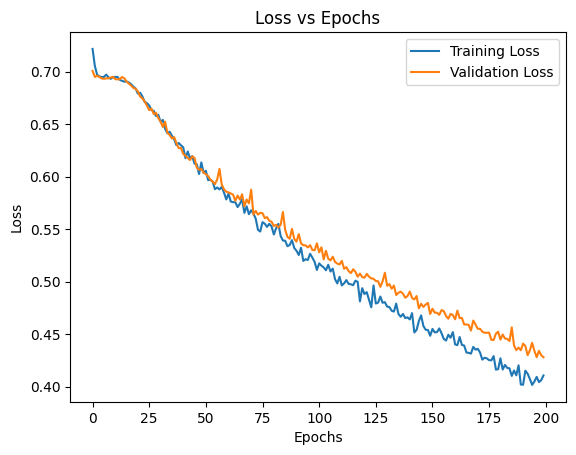

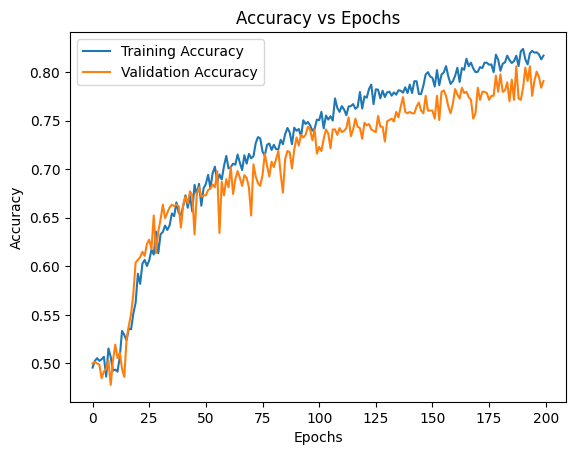

In [24]:
import matplotlib.pyplot as plt

# Plotting loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [25]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test_max, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 467ms/step - accuracy: 0.8174 - loss: 0.4104
Test Loss: 0.4193688929080963
Test Accuracy: 0.7993348240852356


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns

# Generate predictions on the test set
y_pred = model.predict(x_test_max)
y_pred_classes = (y_pred > 0.5).astype("int32")

57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 392ms/step


In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the validation data from the training split
val_split = 0.2
split_idx = int((1 - val_split) * len(x_train_max))
x_val = x_train_max[split_idx:]
y_val = y_train[split_idx:]

In [28]:
# Predict on training set
y_train_pred = model.predict(x_train_max)
y_train_pred_classes = (y_train_pred > 0.5).astype("int32")

# Predict on validation set
y_val_pred = model.predict(x_val)
y_val_pred_classes = (y_val_pred > 0.5).astype("int32")

# Predict on test set
y_test_pred = model.predict(x_test_max)
y_test_pred_classes = (y_test_pred > 0.5).astype("int32")

226/226 ━━━━━━━━━━━━━━━━━━━━ 83s 367ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 357ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step


In [29]:

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


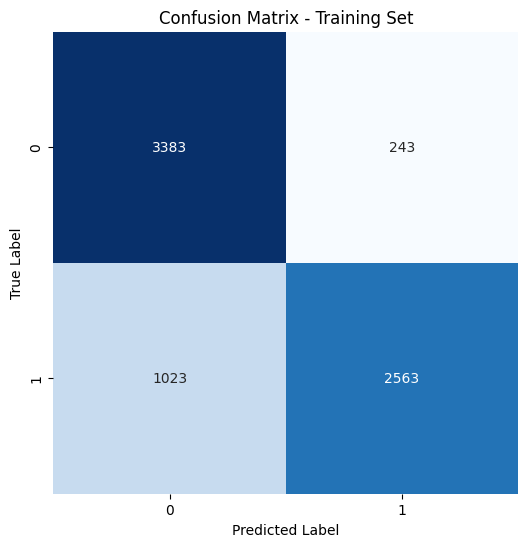

In [30]:
# Plot confusion matrix for training set
plot_confusion_matrix(y_train, y_train_pred_classes, "Training Set")

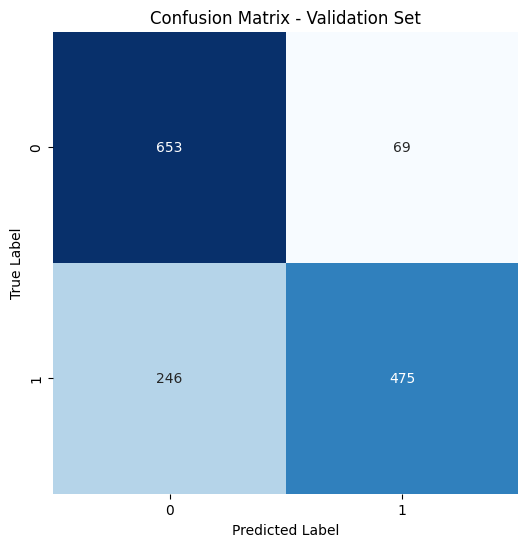

In [31]:
# Plot confusion matrix for validation set
plot_confusion_matrix(y_val, y_val_pred_classes, "Validation Set")

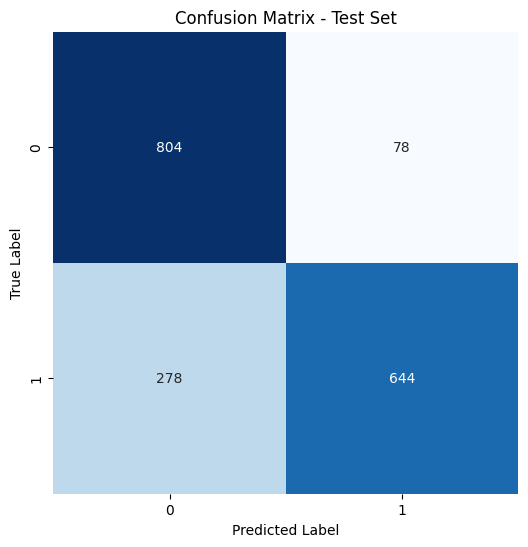

In [32]:
# Plot confusion matrix for test set
plot_confusion_matrix(y_test, y_test_pred_classes, "Test Set")

In [33]:

# Classification report for precision, recall, and F1-score
report = classification_report(y_test, y_pred_classes, target_names=['Undamaged', 'Damaged'])
print(report)

# Calculate F1 Score, Precision, and Recall
f1 = f1_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


              precision    recall  f1-score   support

   Undamaged       0.74      0.91      0.82       882
     Damaged       0.89      0.70      0.78       922

    accuracy                           0.80      1804
   macro avg       0.82      0.81      0.80      1804
weighted avg       0.82      0.80      0.80      1804

F1 Score: 0.7834549878345499
Precision: 0.8919667590027701
Recall: 0.6984815618221258
